In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# telegram
import telegram

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import os
import sys
import datetime
import time
import math

Using TensorFlow backend.


## Data generator reading from .h5 files and returning either training or test batches 

In [ ]:
def myGenerator(set_name, batch_size):
    """
    This generator returns images
    """
    hdf = h5py.File(HDF5_PATH, "r")

    pSensors = hdf[set_name + "/sensors"]
    pLabels = hdf[set_name + "/labels"]

    len_train = pSensors.shape[0]
    
    randomBatchOrder = np.arange(len_train // batch_size)

    while True:
        np.random.shuffle(randomBatchOrder) 
        
        for i in range(len_train // batch_size):
            idx = randomBatchOrder[i]
            shuffled = shuffle(pSensors[idx * batch_size: (idx+1) * batch_size], pLabels[idx * batch_size: (idx+1) * batch_size])
            yield shuffled[0].reshape(-1, train_x.shape[1], train_x.shape[2]), shuffled[1].reshape(-1, train_y.shape[1])

# change model name to match model you want to predict with

In [6]:
model_name = "IMU_N5X_20190121_225302.370-334.05.h5"
smartphone = model_name.split("_")[1]

directory = str(Path.home()) + "/data/plots/" + model_name.split(".")[0]

if not os.path.exists(directory):
    print("Making directory: " + directory)
    os.makedirs(directory)

Making directory: /home/beneste/data/plots/IMU_N5X_20190121_225302


In [3]:
window_size = 50
batch_size = 800

# set screen resolution and pixel size constant (mm)
if smartphone == "N5X":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.06
elif smartphone == "S3Mini":
    pixels = {"width": 480, "height": 800}
    constant_pixels = 0.1089
elif smartphone == "S4":
    pixels = {"width": 1080, "height": 1920}
    constant_pixels = 0.0577
elif smartphone == "N6":
    pixels = {"width": 1440, "height": 2560}
    constant_pixels = 0.05109
    
HDF5_PATH = str(Path.home()) + "/data/hdf-small/" + smartphone + "-win" + str(window_size) + ".hdf"

In [4]:
hdf = h5py.File(HDF5_PATH, "r")

train_x = hdf["train/sensors"]
train_y = hdf["train/labels"]

test_x = hdf["test/sensors"]
test_y = hdf["test/labels"]

In [7]:
%%time
with tf.device('/device:GPU:1'):
    config = tf.ConfigProto(log_device_placement = True, allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config):
        tf.get_default_graph()
        model = Sequential()
        ################################################
        # Enter model layers here from the model above #
        ################################################
        model.add(Dense(256, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(2))
        ################################################
        model.load_weights(str(Path.home()) + "/data/models/" + model_name)

        ### rmse metric for evaluation
        def rmse(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_true - y_pred)))

        optimizer = optimizers.Adam(lr = 0.001, decay = 1e-6)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', rmse])

        ###Feed generator into compiled network: either myGenerator("test", batch_size) or myGenerator("train", batch_size)
        ###Adapt steps to either len(test_x) // batch_size or len(train_x) // batch_size
        hist = model.predict_generator(myGenerator("test", batch_size), steps = len(test_x) // batch_size)

CPU times: user 1.01 s, sys: 201 ms, total: 1.21 s
Wall time: 1.16 s


### Create df from predicted and true points, scale points back to phone coordinates

In [8]:
df = pd.DataFrame(np.concatenate([hist, test_y[:len(hist)]], axis = 1), columns = ["XPred","YPred", "X", "Y"])

df[["XPred", "X"]].multiply(pixels["width"], axis = "index")
df[["YPred", "Y"]].multiply(pixels["height"], axis = "index")

df.XPred = df.XPred.astype(int)
df.YPred = df.YPred.astype(int)
df.X = df.X.astype(int)
df.Y = df.Y.astype(int)

### list of indices where values change (indices.X <- list where true x value has changed)
indices = df.ne(df.shift()).apply(lambda x: x.index[x].tolist())

## Plot all predicted (red) and true points (green), connect them with a line (blue). Orange = diagonal 

In [13]:
#############################################################
### Change write_string to match you want to print into plot#
#############################################################

write_string = "CNN | Acc and Gyro"

#############################################################

export_path = str(Path.home())+"/data/plots/"+ model_name.split(".")[0]

Exporting origin plot to: /home/beneste/data/plots/IMU_N5X_20190121_225302
CPU times: user 28.1 s, sys: 19.2 s, total: 47.3 s
Wall time: 21.7 s


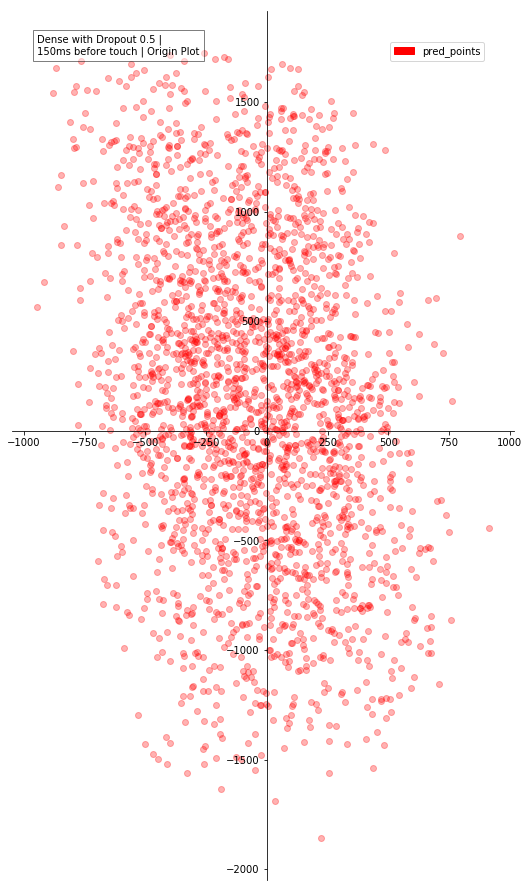

In [14]:
%%time
colors = ['#fc8d59']
labels = ['pred_points']
width= 0.2
patches = []
for i in range(len(colors)):
    patch = mpatches.Patch(color = colors[i], label = labels[i])
    patches.append(patch)
    
fig, ax = plt.subplots(figsize = (9,16))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))

#ax.set_xlim(-1080, 1080)
#ax.set_ylim(1920, -1920)
for x in indices.X[1:]:
    x_true = df.iloc[x-1]['X']
    y_true = df.iloc[x-1]['Y']
    x_pred = df.iloc[x-1]['XPred']
    y_pred = df.iloc[x-1]['YPred']
    x_val = x_pred - x_true
    y_val = y_pred - y_true
    ax.scatter(x_val, -y_val, c = '#fc8d59', alpha = 0.6)

plt.annotate(write_string + " | Origin Plot", xy = (0.05, 0.95), bbox = dict(facecolor = 'white', alpha = 0.5), xycoords = 'axes fraction')
#ax.text(-1000, 2200,  write_string + " | Origin Plot", bbox=dict(facecolor='white', alpha=0.5))
plt.legend(bbox_to_anchor = (0.95,0.97), handles= patches, ncol = 1)

print("Exporting origin plot to: " + export_path)
fig.savefig(export_path + "/origin_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/origin_" + model_name.split(".")[0], bbox_inches = "tight")

Exporting predicition plot to: /home/beneste/data/plots/IMU_N5X_20190121_225302
CPU times: user 52.7 s, sys: 1.24 s, total: 53.9 s
Wall time: 50.5 s


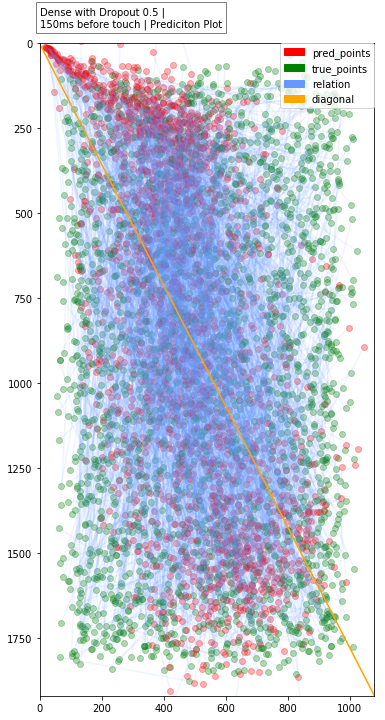

In [15]:
%%time
#patches generation for plot legend
colors = ['#fc8d59','#91cf60','#ffffbf']
labels = ['pred_points','true_points','relation']
patches = []
for i in range(len(colors)):
    patch = mpatches.Patch(color=colors[i], label=labels[i])
    patches.append(patch)

fig, ax = plt.subplots(figsize = (6,12))
ax.set_xlim(0, pixels["width"])
ax.set_ylim(pixels["height"], 0)

for x in indices.X[1:]:
    x_true = df.iloc[x-1]['X']
    y_true = df.iloc[x-1]['Y']
    x_pred = df.iloc[x-1]['XPred']
    y_pred = df.iloc[x-1]['YPred']
    ax.scatter([x_pred],[y_pred], c = '#fc8d59', alpha = 0.3)
    ax.scatter([x_true],[y_true], c = '#91cf60', alpha = 0.3)
    l = mlines.Line2D([x_true,x_pred], [y_true,y_pred], c = '#ffffbf', alpha = 0.1)   
    ax.add_line(l)

ax.text(0, -50, write_string + " | Prediciton Plot", bbox = dict(facecolor='white', alpha = 0.5))
plt.legend(loc = 'upper right', handles = patches, ncol = 1,  borderaxespad = 0.)


print("Exporting predicition plot to: " + export_path)
fig.savefig(export_path + "/pred_" + model_name.split(".")[0] + ".pdf", bbox_inches = "tight")
fig.savefig(export_path + "/pred_" + model_name.split(".")[0], bbox_inches = "tight")

### Add new rows to df, describe df (mean,std,quartiles)

In [12]:
%%time
def calculate_euc(row):
    return math.sqrt((row['XPred'] - row['YPred'])**2 + (row['X'] - row['Y'])**2)

def calculate_eucMM(row):
    return row['euc'] * constant_pixels
    
def calculate_x_error(row):
    return abs(row["XPred"] - row["X"])

def calculate_y_error(row):
    return abs(row["YPred"] - row["Y"])

print("Calculating euclidean distance.")
df['euc'] = df.apply(calculate_euc, axis = 1)

print("Calculating euclidean distance in mm.")
df['eucMM'] = df.apply(calculate_eucMM, axis = 1)

print("Calculating error in x-direction.")
df['x_err'] = df.apply(calculate_x_error, axis = 1)

print("Calculating error in y-direction.")
df['y_err'] = df.apply(calculate_y_error, axis = 1)

csv_path = str(Path.home())+"/data/plots/"+model_name.split(".")[0] + "/" + model_name.split(".")[0] + ".csv"
print("Writing csv to: " + csv_path)
df.to_csv(csv_path, header = True)

Calculating euclidean distance.
Calculating euclidean distance in mm.
Calculating error in x-direction.
Calculating error in y-direction.
Writing csv to: /home/beneste/data/plots/IMU_N5X_20190121_225302/IMU_N5X_20190121_225302.csv
CPU times: user 563 ms, sys: 7.78 ms, total: 570 ms
Wall time: 550 ms


In [87]:
df.describe()

,XPred,YPred,X,Y,euc,eucMM,x_err,y_err
count,2400.0,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,529.0,944.0,533.515417,962.740000,759.684157,45.581049,230.604583,441.030000
std,0.0,0.0,265.367583,508.334808,328.626806,19.717608,131.300078,253.312203
min,529.0,944.0,55.000000,35.000000,415.010843,24.900651,0.000000,0.000000
25%,529.0,944.0,302.000000,520.750000,478.402550,28.704153,116.000000,221.750000
50%,529.0,944.0,535.000000,954.000000,660.621677,39.637301,233.500000,447.500000
75%,529.0,944.0,771.250000,1418.000000,967.071553,58.024293,344.000000,661.000000
max,529.0,944.0,1024.000000,1875.000000,1789.778199,107.386692,495.000000,931.000000
